# Assignment 2


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from graphviz import Digraph
import numpy as np
import pandas as pd
import copy as cp
from collections import OrderedDict as odict
from itertools import product, combinations
from tabulate import tabulate

In [2]:
from assigment2 import GraphicalModel

## Representation

### 1. Insert and remove nodes.

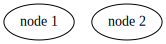

In [3]:
g = GraphicalModel()
g.insert('node 1', ('yes', 'no'))
g.insert('node 2', ('yes', 'no'))

g.showGraph()

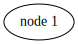

In [4]:
g.remove('node 2')
g.showGraph()

### 2. Connect and disconnect nodes with edges.

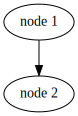

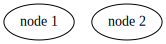

In [5]:
g.insert('node 2', ('yes', 'no'))
g.connect('node 1', 'node 2')
g.showGraph()
g.disconnect('node 1', 'node 2')
g.showGraph()

### 3. Specify probabilities for a node.

Some useful function helps to visualize.

In [6]:
def printFactor(f):
    table = list()
    for key, item in f['table'].items():
        k = list(key)
        k.append(item)
        table.append(k)
    dom = list(f['dom'])
    dom.append('Pr')
    print(tabulate(table, headers=dom, tablefmt='orgtbl'))

def prob(factor, *entry):
    return factor['table'][entry]

In [8]:
g.connect('node 1', 'node 2')
g.factorize('node 1', [0.1, 0.9])
print('node 1:')
printFactor(g.factors['node 1'])
g.factorize('node 2', [0.5, 0.5, 0.3, 0.7], ['node 1'])
print('node 2:')
printFactor(g.factors['node 2'])

node 1:
| node 1   |   Pr |
|----------+------|
| yes      |  0.1 |
| no       |  0.9 |
node 2:
| node 1   | node 2   |   Pr |
|----------+----------+------|
| yes      | yes      |  0.5 |
| yes      | no       |  0.5 |
| no       | yes      |  0.3 |
| no       | no       |  0.7 |


### 4. Load from .net file.

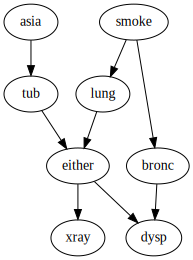

| tub   | lung   | either   |   Pr |
|-------+--------+----------+------|
| yes   | yes    | yes      |    1 |
| yes   | yes    | no       |    0 |
| yes   | no     | yes      |    1 |
| yes   | no     | no       |    0 |
| no    | yes    | yes      |    1 |
| no    | yes    | no       |    0 |
| no    | no     | yes      |    0 |
| no    | no     | no       |    1 |


In [9]:
g = GraphicalModel()
g.load('small/asia.net')
g.showGraph()
printFactor(g.factors['either'])